### Tasks
#### Replace Exact neighbors with LSH
#### Verify near neigbor approach working correctly
#### Try multiple datasets
#### Create a script
#### Fine tune the model

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time
import copy

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

In [21]:
random.seed(123)

In [22]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [23]:
df=pd.read_csv("HIGGS.csv",header=None, nrows=100)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [24]:
print(df.size)

2900


<AxesSubplot: xlabel='0', ylabel='count'>

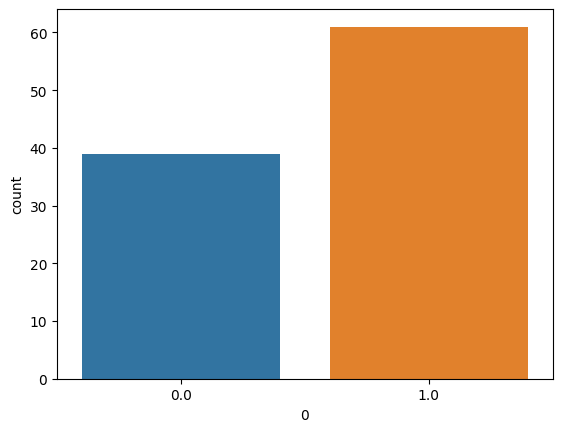

In [25]:
sns.countplot(x = 0, data=df)

In [26]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [27]:
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2
RANDOM_SIZE = [100,80,60,40,20, 0]

In [28]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [29]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [30]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], index
        
    def __len__ (self):
        return len(self.X_data)
    
    def getBatch(self, indices, withIndex = False):
        if withIndex:
            return self.X_data[(indices)], self.y_data[(indices)], indices
        else:
            return self.X_data[(indices)], self.y_data[(indices)]
    

train_dataset = ClassifierDataset(torch.tensor(X_train, dtype=torch.float32 ,device=device), torch.tensor(y_train, dtype=torch.long, device=device))
val_dataset = ClassifierDataset(torch.tensor(X_val, dtype=torch.float32, device=device), torch.tensor(y_val, dtype=torch.long, device=device))
test_dataset = ClassifierDataset(torch.tensor(X_test, dtype=torch.float32, device=device), torch.tensor(y_test, dtype=torch.long, device=device))

In [104]:
global in_mem_neighbors, cluster
in_mem_neighbors = dict()
cluster = torch.zeros(len(train_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [109]:
def compute_next_batch(batch, dataset, batch_norm, batch_size, indices, debug=False):
    full_data = dataset.getBatch(list(range(len(dataset))))[0]
    
    if debug:
        print("batch_norm", batch_norm)
    
    ## put top3 neighbors in memory. Manually verify that the neighbors are in fact l2-norm 
    for pos, index in enumerate(indices):
        if index.int().item() not in in_mem_neighbors:
               in_mem_neighbors[index.int().item()] = torch.linalg.norm(full_data - batch[pos], dim = 1).argsort()[:3].cpu() 

    if debug:
        print("neighbor_dict", in_mem_neighbors)
    
    ## concatenate all top neighors into single tensor
    next_batch = torch.cat(tuple([in_mem_neighbors[x.int().item()] for x in indices]))
    if debug:
        print("candidates", next_batch)
    ## assign probability of selection to all candidates in next batch 
    next_batch_weights = torch.cat(tuple([torch.tensor([x.item()]*3) for x in batch_norm]))
    if debug:
        print("p-weights", next_batch_weights)
    ## weighted selection of next batch. Verify that the probability distribution is being followed
    next_batch = next_batch[next_batch_weights.multinomial(1)]
    if debug:
        print("final_batch", next_batch)
    cluster[next_batch] += 1

In [110]:
compute_next_batch(train_dataset.getBatch([1,2,3])[0], train_dataset, torch.tensor([20, 30, 50], dtype=torch.float32), 3, torch.tensor([1,2,3], dtype=torch.float32), debug=True)

batch_norm tensor([20., 30., 50.])
neighbor_dict {1: tensor([ 1, 40, 61]), 2: tensor([ 2, 21, 41]), 3: tensor([ 3, 62, 55])}
candidates tensor([ 1, 40, 61,  2, 21, 41,  3, 62, 55])
p-weights tensor([20., 20., 20., 30., 30., 30., 50., 50., 50.])
final_batch tensor([41])


In [111]:
cluster = torch.zeros(len(train_dataset))
for _ in range(1000):
    compute_next_batch(train_dataset.getBatch([1,2,3])[0], train_dataset, torch.tensor([20, 30, 50], dtype=torch.float32), 3, torch.tensor([1,2,3], dtype=torch.float32))

In [113]:
print("Expected value: ", 200," Actual value: ", cluster[1] + cluster[40] + cluster[61])
print("Expected value: ", 300," Actual value: ", cluster[2] + cluster[21] + cluster[41])
print("Expected value: ", 500," Actual value: ", cluster[3] + cluster[62] + cluster[55])

Expected value:  200  Actual value:  tensor(209.)
Expected value:  300  Actual value:  tensor(302.)
Expected value:  500  Actual value:  tensor(489.)
